In [1]:
pip install tensorflow numpy matplotlib


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/5.5 MB ? eta -:--:--
   ----- ---------------------------------- 0.8/5.5 MB 5.6 MB/s eta 0:00:01
   --------------- ------------------------ 2.1/5.5 MB 5.3 MB/s eta 0:00:01
   ---------------------- ----------------- 3.1/5.5 MB 5.3 MB/s eta 0:00:01
   ---------------------------- ----------- 3.9/5.5 MB 5.1 MB/s eta 0:00:01
   ------------------------------------ --- 5.0/5.5 MB 5.1 MB/s eta 0:00:01
   -------------------------------------- - 5.2/5.5 MB 5.1 MB/s eta 0:00:01
   -------------------------------------- - 5.2/5.5 MB 5.1 MB/s eta 0:00:01
   -------------------------------------- - 5.2/5.5 MB 5.1 MB/s eta 0:00:01
   -------------------------------------- - 5.2/5.5 MB 5.1 MB/s eta 0:00:01
   -------------------------------------- - 5.2/5.5 MB 5.1 MB/s eta 0:00:01
   ---------------------------------------- 5.5/5.5 MB 2.4 MB/s eta 0:00:00
  Attempting unin

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image as kimage
import numpy as np
import matplotlib.pyplot as plt


In [12]:
def load_and_process_img(img_path):
    img = kimage.load_img(img_path, target_size=(224, 224))
    img = kimage.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

content_img = load_and_process_img('D:\\python programs\\butterfly.jpg')
style_img = load_and_process_img('D:\\python programs\\butterfly.jpg')



In [13]:
def get_model():
    base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False)
    content_layers = ['block5_conv2']  # Layer for content
    style_layers = [
        'block1_conv1',
        'block2_conv1',
        'block3_conv1',
        'block4_conv1',
        'block5_conv1'
    ]  # Layers for style
    
    # Create a model that returns the outputs of these layers
    outputs = [base_model.get_layer(name).output for name in (content_layers + style_layers)]
    model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)
    return model

model = get_model()


In [14]:
def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    gram = tf.matmul(tf.transpose(a), a)
    return gram

def style_loss(base_style, target):
    return tf.reduce_mean(tf.square(gram_matrix(base_style) - gram_matrix(target)))


In [15]:
def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    gram = tf.matmul(tf.transpose(a), a)
    return gram

def style_loss(base_style, target):
    return tf.reduce_mean(tf.square(gram_matrix(base_style) - gram_matrix(target)))


In [16]:
def total_loss(content_weight, style_weight, content, style, target):
    c_loss = content_loss(content, target['content'])
    s_loss = style_loss(style, target['style'])
    return content_weight * c_loss + style_weight * s_loss


In [17]:
import tensorflow as tf

content_weight = 1e3
style_weight = 1e-2
target_image = tf.Variable(content_img)

optimizer = tf.optimizers.Adam(learning_rate=0.02)

@tf.function
def train_step():
    with tf.GradientTape() as tape:
        outputs = model(target_image)
        content_outputs = outputs[:1]
        style_outputs = outputs[1:]

        loss = total_loss(content_weight, style_weight, content_outputs[0], style_outputs[0], {
            'content': model(content_img)[0],
            'style': model(style_img)[1:]
        })
    grad = tape.gradient(loss, target_image)
    optimizer.apply_gradients([(grad, target_image)])


In [18]:
@tf.function
def train_step():
    with tf.GradientTape() as tape:
        outputs = model(target_image)
        
        # Get the content and style outputs
        content_outputs = outputs[0]  # First element for content
        style_outputs = outputs[1:]  # Remaining elements for styles

        # Calculate losses
        loss = total_loss(
            content_weight, 
            style_weight, 
            content_outputs, 
            style_outputs,
            {
                'content': model(content_img)[0],  # Get content from content image
                'style': [model(style_img)[i] for i in range(1, len(model(style_img)))],  # Get styles from style image
            }
        )
    grad = tape.gradient(loss, target_image)
    optimizer.apply_gradients([(grad, target_image)])


In [19]:
def total_loss(content_weight, style_weight, content, styles, target):
    c_loss = content_loss(content, target['content'])
    s_loss = sum(style_loss(style, target_style) for style, target_style in zip(styles, target['style']))
    return content_weight * c_loss + style_weight * s_loss


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


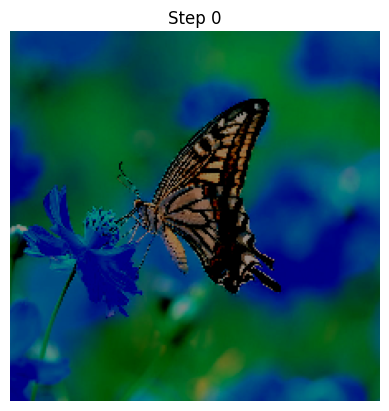

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


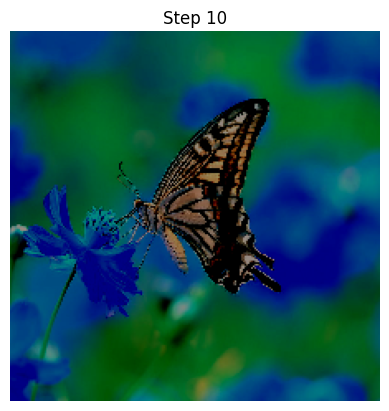

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


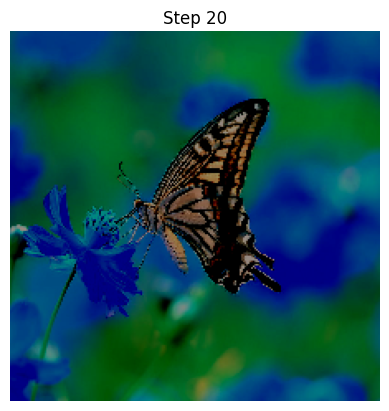

In [20]:
epochs = 30
for i in range(epochs):
    train_step()
    if i % 10 == 0:
        plt.imshow(np.squeeze(target_image.numpy(), axis=0) / 255.0)
        plt.axis('off')
        plt.title(f'Step {i}')
        plt.show()


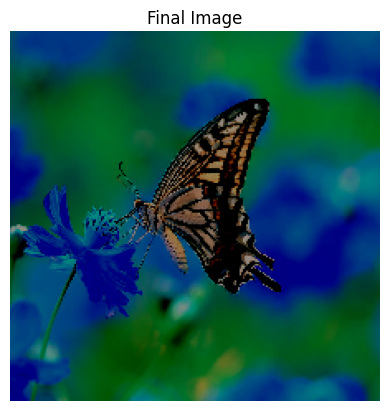

In [21]:
final_image = np.squeeze(target_image.numpy(), axis=0)
final_image = np.clip(final_image, 0, 255).astype('uint8')

plt.imshow(final_image)
plt.axis('off')
plt.title('Final Image')
plt.show()
